In [1]:
import numpy as np
from skimage import io, filters
from tifffile import imsave

import matplotlib.pyplot as plt
import cmasher as cmr

### Read the stacks

In [2]:
# Read all the images in each directory
living_Ecad    = io.imread('Data/20220713_Immunofluorescence/data/living_Ecad.tif')
living_isotype = io.imread('Data/20220713_Immunofluorescence/data/living_isotype.tif')
fixed_Ecad     = io.imread('Data/20220713_Immunofluorescence/data/fixed_Ecad.tif')
fixed_isotype  = io.imread('Data/20220713_Immunofluorescence/data/fixed_isotype.tif')

# Subtract the base line
base_line = np.min([living_Ecad.min(), living_isotype.min(), fixed_Ecad.min(), fixed_isotype.min()])
living_Ecad    -= base_line
living_isotype -= base_line
fixed_Ecad     -= base_line
fixed_isotype  -= base_line

# Save the stackes in tiff format
imsave('Data/20220713_Immunofluorescence/results/living_Ecad.tif', living_Ecad)
imsave('Data/20220713_Immunofluorescence/results/living_isotype.tif', living_isotype)
imsave('Data/20220713_Immunofluorescence/results/fixed_Ecad.tif', fixed_Ecad)
imsave('Data/20220713_Immunofluorescence/results/fixed_isotype.tif', fixed_isotype)

### Show the summery images and compare the results in a histograme

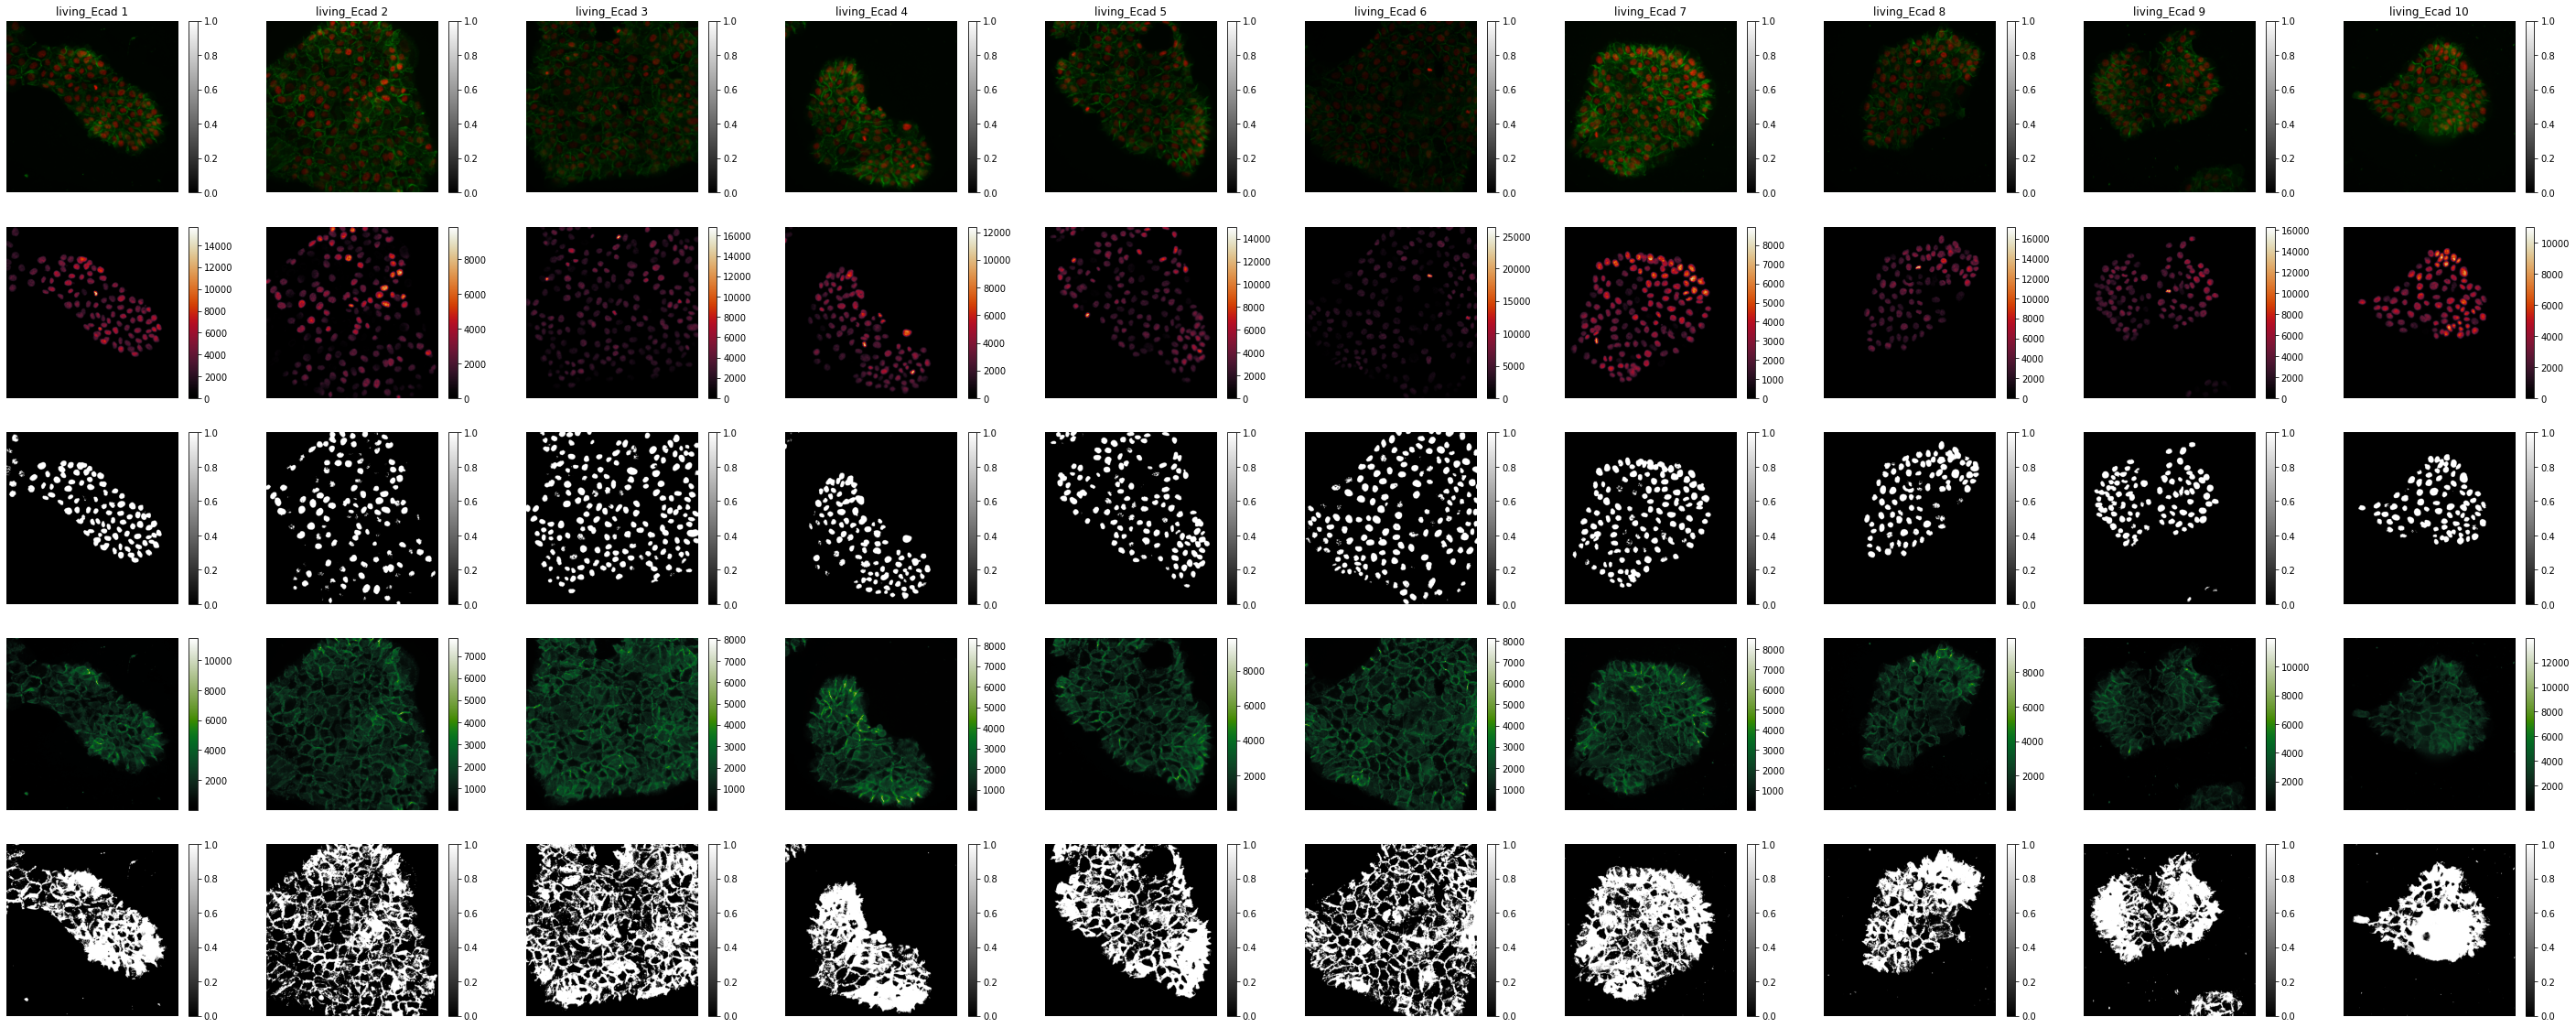

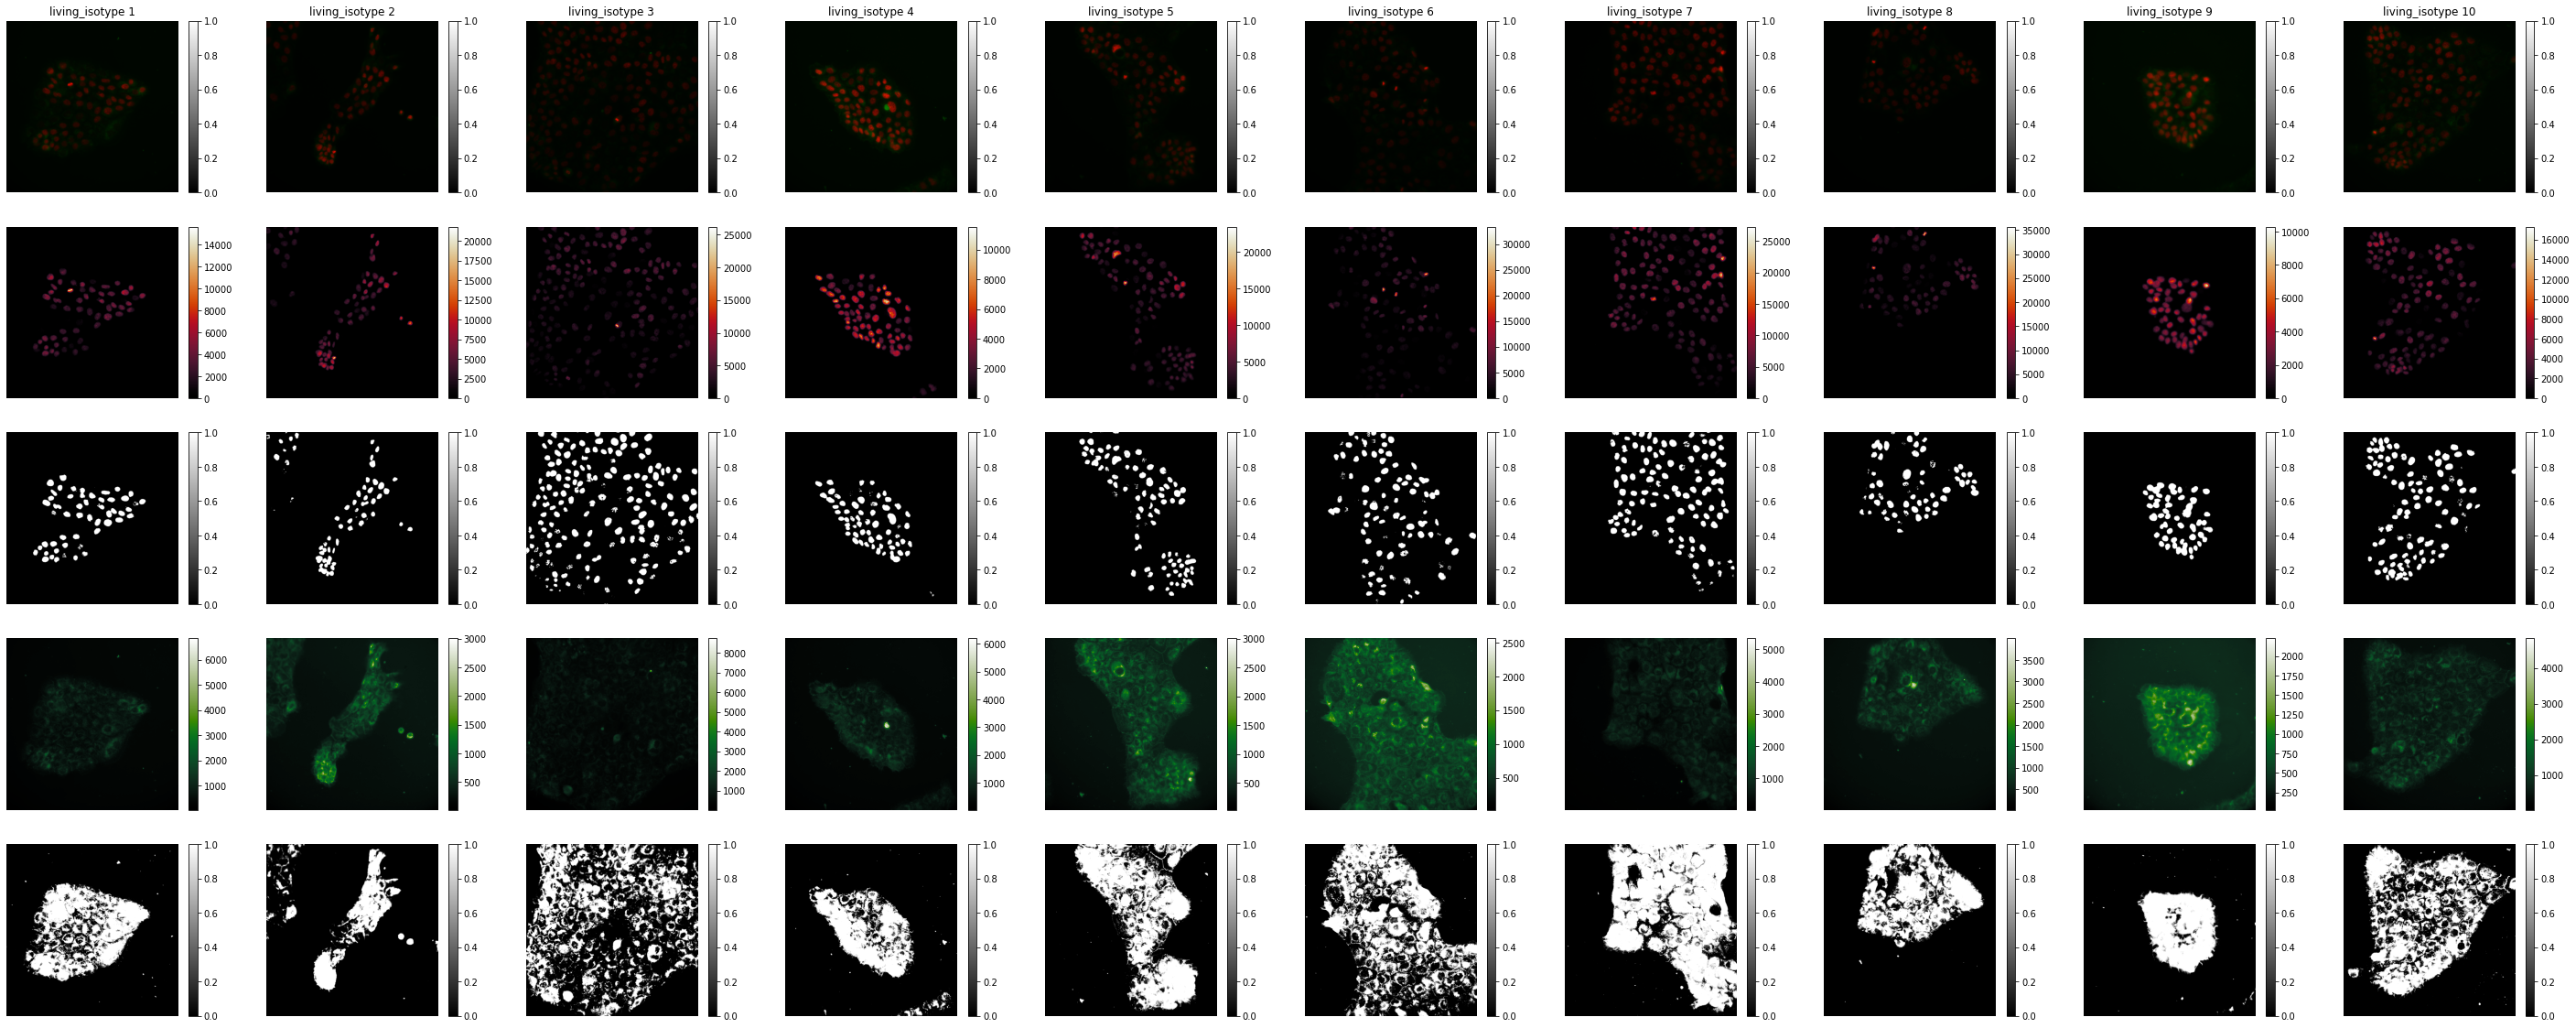

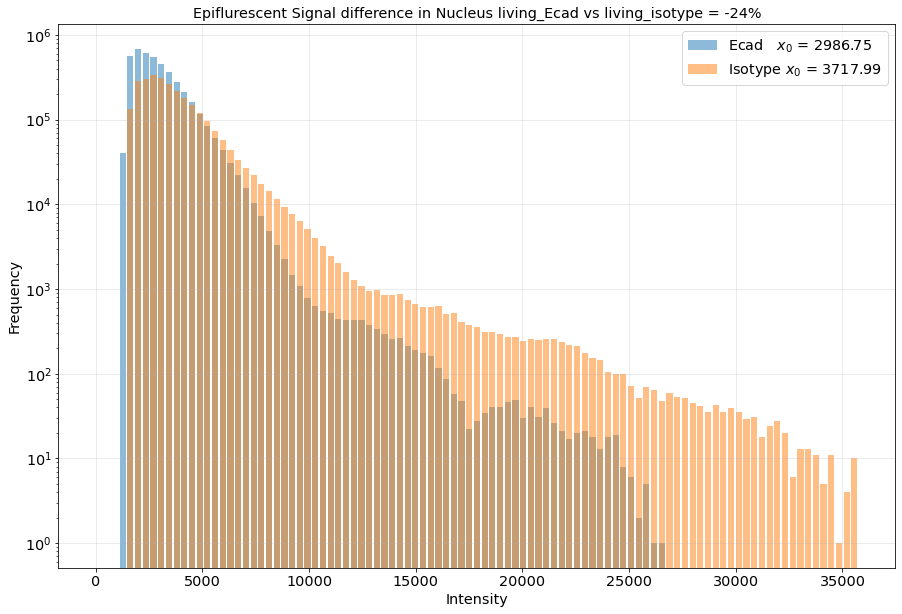

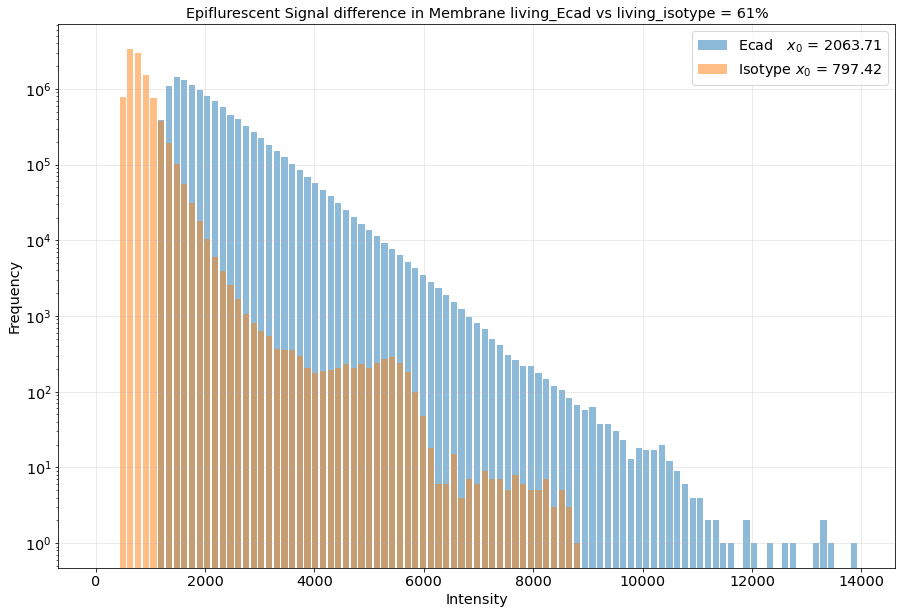

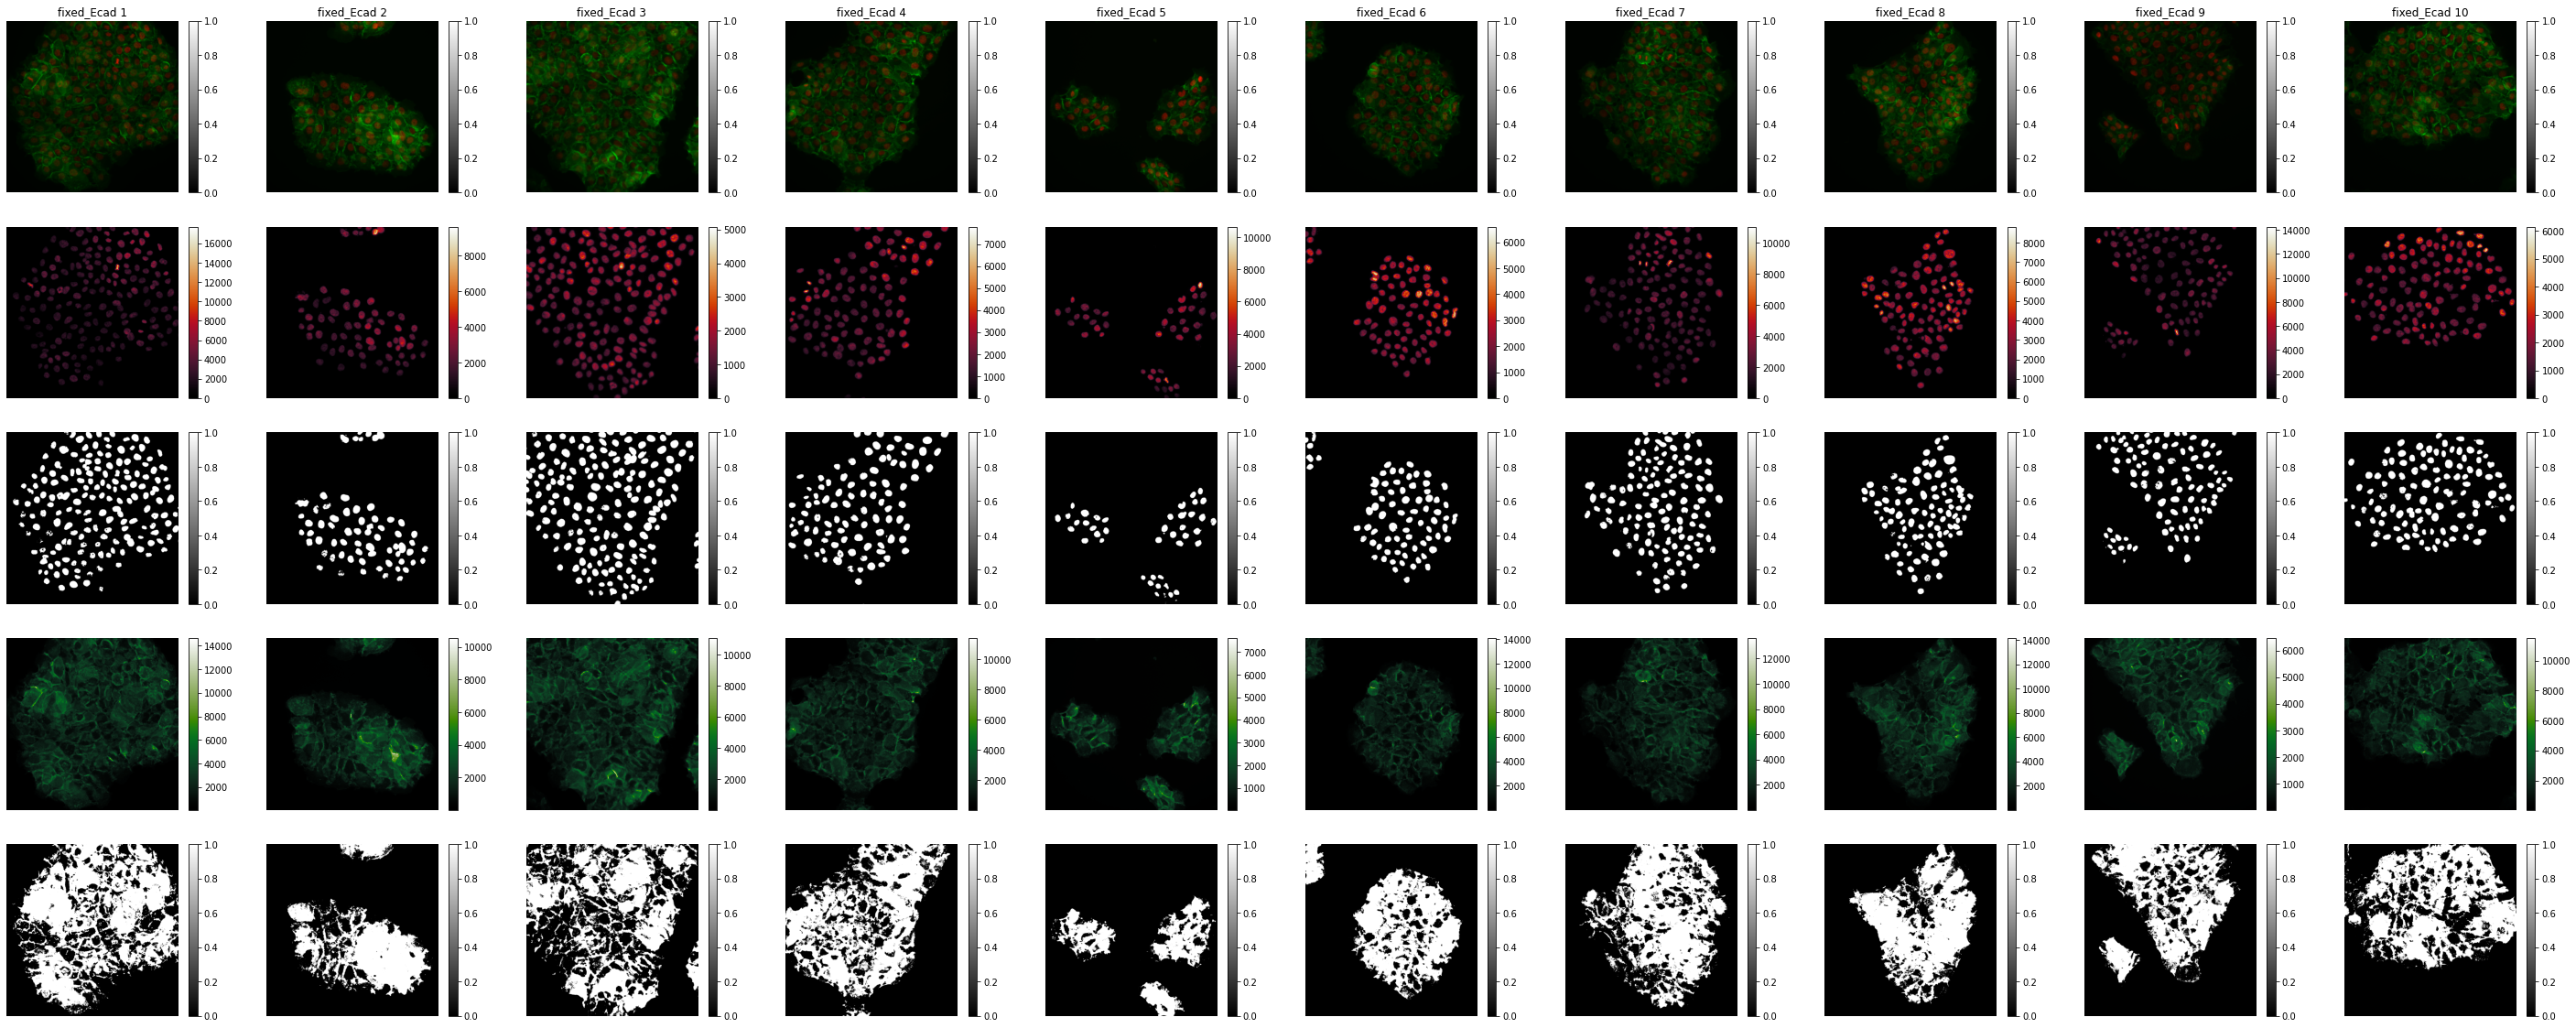

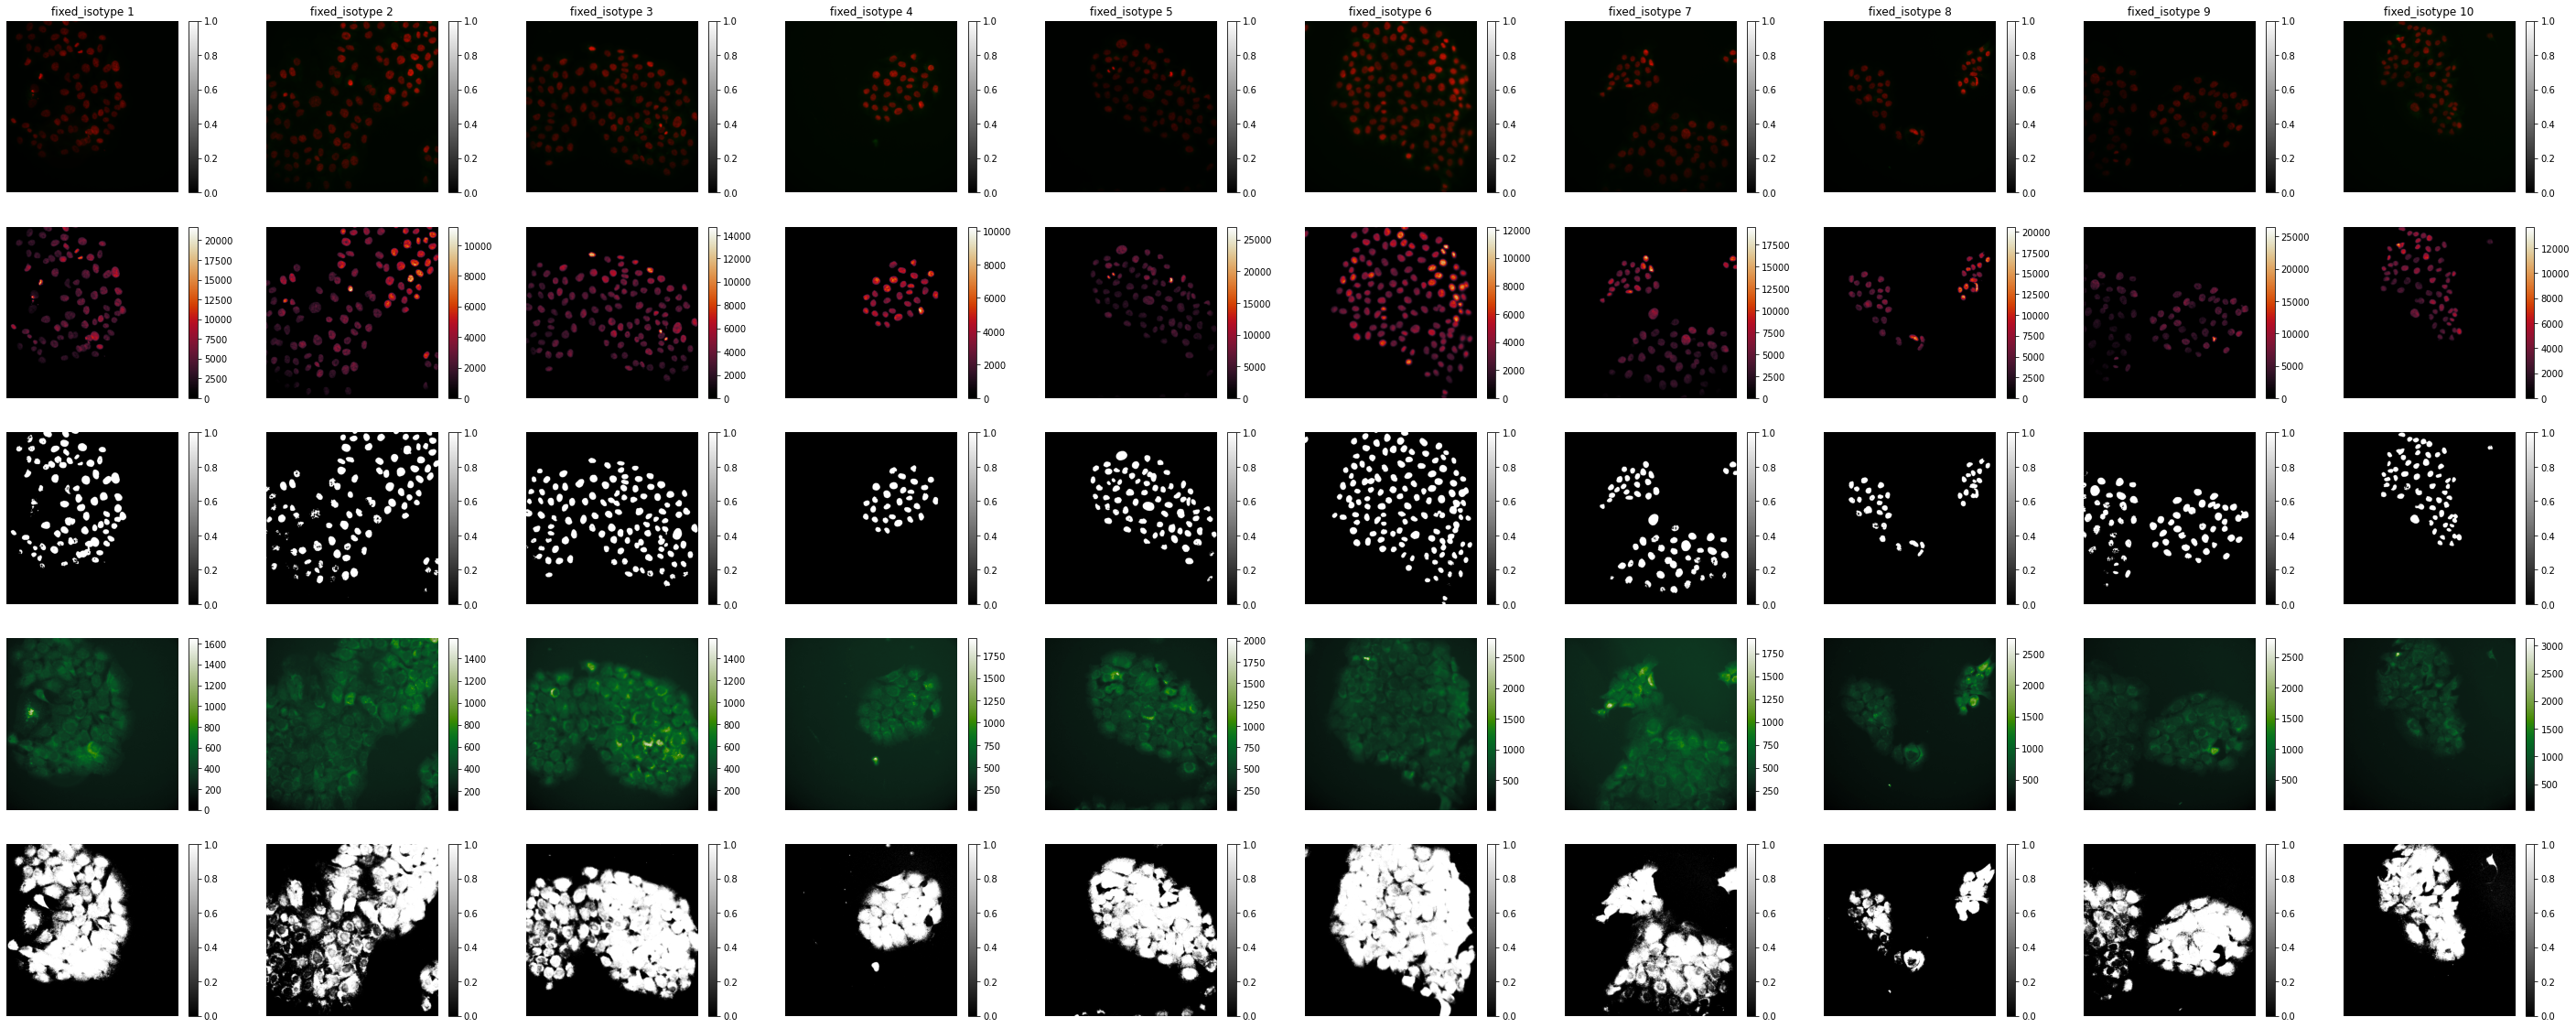

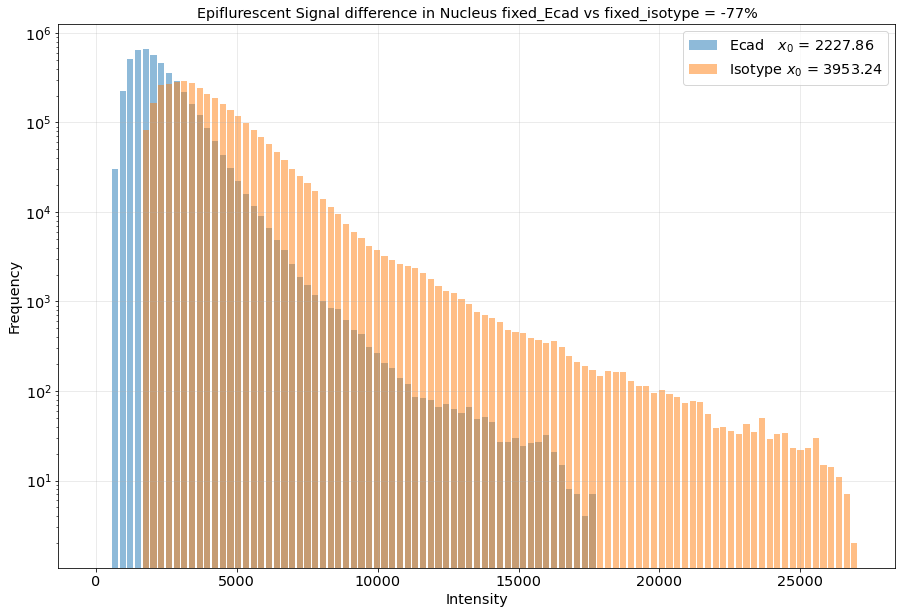

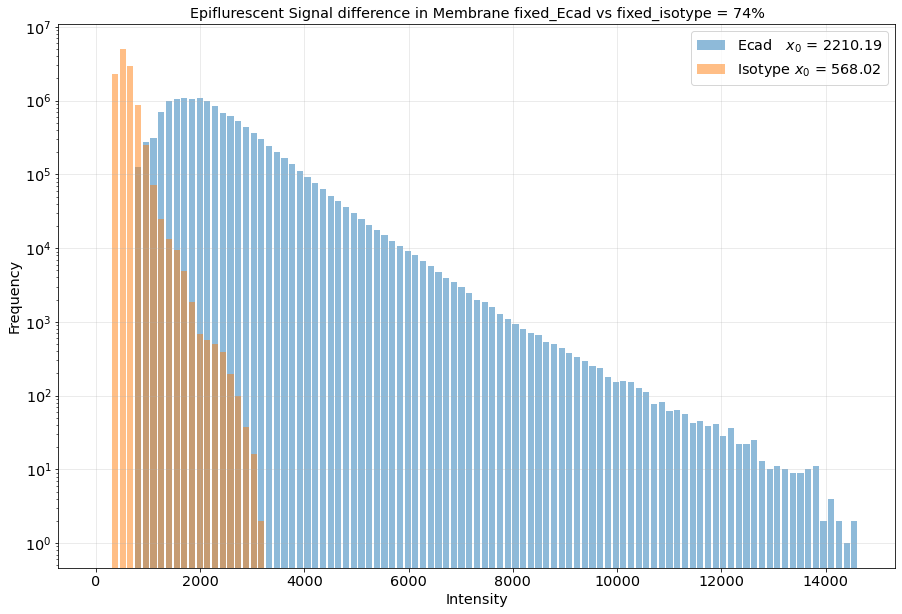

In [3]:
for positive, negative, positive_name, negative_name in zip([living_Ecad, fixed_Ecad], [living_isotype, fixed_isotype], ['living_Ecad', 'fixed_Ecad'], ['living_isotype', 'fixed_isotype']):
    
    # Plot all the images
    for sample , sample_name in zip([positive, negative], [positive_name, negative_name]):
        plt.figure(figsize=(5*sample.shape[0], 20))
        
        # RGB image
        for i, img in enumerate(sample):
            red   = img[0]/np.max([img[0].max(), img[1].max()])
            green = img[1]/np.max([img[0].max(), img[1].max()])
            blue  = np.zeros_like(red)

            plt.subplot(5, sample.shape[0], i+1)
            plt.imshow(np.dstack((red, green, blue)), cmap='gray')
            plt.axis('off')
            plt.title(f'{sample_name} {i+1}')
            plt.colorbar()
        
        # Nucleus image
        for i, img in enumerate(sample[:,0]):
            plt.subplot(5, sample.shape[0], i+1+sample.shape[0])
            plt.imshow(img, cmap=cmr.sunburst)
            plt.axis('off')
            plt.colorbar()
        
        # Nucleus mask
        for i, img in enumerate(sample[:,0]):
            plt.subplot(5, sample.shape[0], i+1+2*sample.shape[0])
            plt.imshow(img > filters.threshold_otsu(img), cmap='gray')
            plt.axis('off')
            plt.colorbar()
        
        # Membrane image
        for i, img in enumerate(sample[:,1]):
            plt.subplot(5, sample.shape[0], i+1+3*sample.shape[0])
            plt.imshow(img, cmap=cmr.jungle)
            plt.axis('off')
            plt.colorbar()
        
        # Membrane mask
        for i, img in enumerate(sample[:,1]):
            plt.subplot(5, sample.shape[0], i+1+4*sample.shape[0])
            plt.imshow(img > filters.threshold_otsu(img), cmap='gray')
            plt.axis('off')
            plt.colorbar()

        plt.savefig(f'Data/20220713_Immunofluorescence/results/summary_{sample_name}')
        plt.show()
    
    # plot the comparison histograms
    for channel, channel_name in enumerate(['Nucleus', 'Membrane']):
        signal_positive = np.array([img * (img > filters.threshold_otsu(img)) for img in positive[:,channel]])
        signal_negative = np.array([img * (img > filters.threshold_otsu(img)) for img in negative[:,channel]])

        # Flat the array and exclud the zero
        signal_positive = signal_positive[signal_positive != 0].ravel()
        signal_negative = signal_negative[signal_negative != 0].ravel()

        # plot a comparison of the two histogram
        plt.figure(figsize=(15,10))
        plt.hist(signal_positive, bins=np.linspace(0, np.max([signal_positive.max(), signal_negative.max()]), 100), rwidth=0.8, label=f'Ecad   $x_0$ = {signal_positive.mean():.2f}', alpha=0.5)
        plt.hist(signal_negative, bins=np.linspace(0, np.max([signal_positive.max(), signal_negative.max()]), 100), rwidth=0.8, label=f'Isotype $x_0$ = {signal_negative.mean():.2f}', alpha=0.5)
        plt.title(f'Epiflurescent Signal difference in {channel_name} {positive_name} vs {negative_name} = {((signal_positive.mean() - signal_negative.mean())/ signal_positive.mean())*100:.0f}%', fontsize='x-large')
        plt.xlabel('Intensity', fontsize='x-large')
        plt.xticks(fontsize='x-large')
        plt.yticks(fontsize='x-large')
        plt.yscale('log')
        plt.ylabel('Frequency', fontsize='x-large')
        plt.legend(fontsize='x-large')
        plt.grid(alpha=0.3)

        plt.savefig(f'Data/20220713_Immunofluorescence/results/comparison_{channel_name}_{positive_name}_vs_{negative_name}')
        plt.show()